In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Dense,Conv2D, MaxPool2D,Flatten,BatchNormalization,Input
from  tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer


/Users/krishna009/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dataSet , dataset_info = tfds.load('malaria' , with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

2024-03-30 14:31:12.132592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-30 14:31:12.132617: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-30 14:31:12.132621: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-30 14:31:12.132658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 14:31:12.132679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
for data in dataSet[0].take(1):
    print(data)


(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/krishna009/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

In [5]:
dataSet

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataSet = tf.data.Dataset.range(10)
# print(list(dataSet.as_numpy_iterator()))
# dataset_size = (len(dataSet))

# train_dataset = dataSet.take(int(TRAIN_RATIO*dataset_size))
# print(list(train_dataset.as_numpy_iterator()))

# val_test_dataset = dataSet.skip(int(TRAIN_RATIO*dataset_size))
# val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))
# print(list(val_dataset.as_numpy_iterator()))

# test_dataset = val_test_dataset.skip(int(TEST_RATIO*dataset_size))
# print(list(test_dataset.as_numpy_iterator()))


In [7]:
def splits(dataSet,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
    dataset_size = (len(dataSet))
    train_dataset = dataSet.take(int(TRAIN_RATIO*dataset_size))
 

    val_test_dataset = dataSet.skip(int(TRAIN_RATIO*dataset_size))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))
 

    test_dataset = val_test_dataset.skip(int(TEST_RATIO*dataset_size))
    return train_dataset, val_dataset, test_dataset


In [8]:
train, val, test = splits(dataSet[0] ,TRAIN_RATIO , VAL_RATIO , TEST_RATIO)


In [9]:
val

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## DATA VISUALIZATION

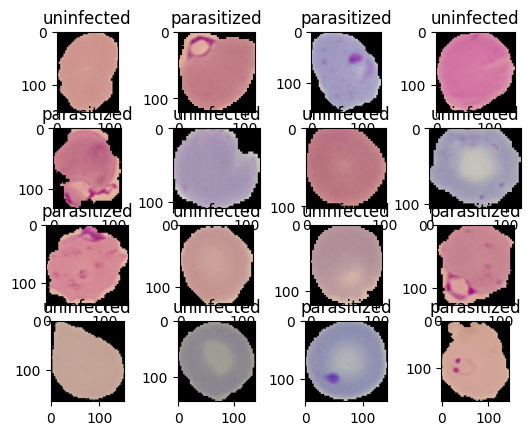

In [10]:
for i, (img, label) in enumerate(train.take(16)):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(img)
    plt.title(dataset_info.features['label'].int2str(label))

## Data Processing 

In [11]:
IM_SIZE = 224
def resizing_rescale(image, label):
    return tf.image.resize(image, [IM_SIZE, IM_SIZE]) / 225.0, label


In [12]:
train = train.map(resizing_rescale)
val = val.map(resizing_rescale)
test = test.map(resizing_rescale)

In [13]:
for img, label in train.take(1):

    print(img, label)


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [14]:
# shuffling Data
train = train.shuffle(buffer_size=8 , reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
# shuffling Data
val = val.shuffle(buffer_size=8 , reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
train, val

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [17]:
model = tf.keras.Sequential([
    InputLayer(input_shape =(IM_SIZE,IM_SIZE,3) ),

    Conv2D(
    filters=6,
    kernel_size=3,
    strides=(1, 1),
    padding='valid',
    activation = 'relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2 , strides = 2 ),

    Conv2D(
    filters=16,
    kernel_size=5,
    strides=(1, 1),
    padding='valid',
    activation = 'relu'
    ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2 , strides = 2 ),

    Flatten(),
    
    Dense(100 , activation = 'relu'),
    BatchNormalization(),
    Dense(10 , activation = 'relu'),
    BatchNormalization(),
    Dense(1 , activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 107, 107, 16)      64        
 chNormalization)                                                
                                                        

## Functional Model

In [17]:
fun_input = Input(shape = (IM_SIZE,IM_SIZE,3) , name = "Input Image")
x =Conv2D(filters=6,kernel_size=3,strides=1 ,padding='valid', activation = 'relu' )(fun_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2 , strides = 2 )(x)
x = Conv2D(filters=16,kernel_size=5,strides=1, padding='valid',activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2 , strides = 2 )(x)

lenet_model_Feature = Model(fun_input , output , name = "features_extract")



In [18]:
fun_input = Input(shape = (IM_SIZE,IM_SIZE,3) , name = "Input Image")
x =lenet_model_Feature(fun_input)
x = Flatten()(x)
x = Dense(100 , activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10 , activation = 'relu')(x)
x = BatchNormalization()(x)
fun_out = Dense(1 , activation = 'sigmoid')(x)
lenet_model_func = Model(fun_input , fun_out , name = "Lenet_Model")



In [19]:
lenet_model_func.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 features_extract (Function  (None, 53, 53, 16)        2672      
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 100)               4494500   
                                                                 
 batch_normalization_2 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                

In [18]:
y  = [0,1,0,0]
y_hat = [1,0.1,0.7,0.01]
bce = tf.keras.losses.BinaryCrossentropy()


In [19]:
bce(y,y_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=4.7124615>

In [20]:
model.compile(optimizer= Adam(learning_rate=0.01),
              loss = bce,
              #metrics = RootMeanSquaredError()
              
              )

In [46]:
lenet_model_func.compile(optimizer= Adam(learning_rate=0.01),
              loss = bce,
              #metrics = RootMeanSquaredError()
              
              )

In [21]:
with tf.device('/GPU:0'):
    # Build and train your model
    history = model.fit(train, epochs=20,validation_data=val,  verbose=1)


Epoch 1/20


2024-03-27 18:54:37.408673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


689/689 [==============================] - 41s 57ms/step - loss: 0.6165 - val_loss: 0.8371
Epoch 2/20
689/689 [==============================] - 39s 56ms/step - loss: 0.3765 - val_loss: 0.9863
Epoch 3/20
689/689 [==============================] - 39s 56ms/step - loss: 0.3115 - val_loss: 0.3671
Epoch 4/20
689/689 [==============================] - 39s 56ms/step - loss: 0.2877 - val_loss: 1.6249
Epoch 5/20
689/689 [==============================] - 41s 59ms/step - loss: 0.2788 - val_loss: 0.3454
Epoch 6/20
689/689 [==============================] - 46s 66ms/step - loss: 0.2761 - val_loss: 0.3602
Epoch 7/20
689/689 [==============================] - 47s 69ms/step - loss: 0.2688 - val_loss: 0.4196
Epoch 8/20
689/689 [==============================] - 46s 67ms/step - loss: 0.2598 - val_loss: 0.4246
Epoch 9/20
689/689 [==============================] - 48s 70ms/step - loss: 0.2546 - val_loss: 0.5049
Epoch 10/20
689/689 [==============================] - 48s 69ms/step - loss: 0.2545 - val_los

In [ ]:

# Build and train your model
history = lenet_model_func.fit(train, epochs=20,validation_data=val,  verbose=1)


In [25]:
model.save('my_model.h5')


In [21]:
from keras.models import load_model

model = load_model('my_model.h5')


In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','vall_loss'])
plt.title("Loss Curve ")



NameError: name 'history' is not defined

In [23]:
# shuffling Data
test = test.batch(1)

In [24]:
losss =  model.evaluate(test,verbose=0)

2024-03-28 13:54:29.821174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [25]:
losss

0.2186281532049179

In [26]:
def MalPredict(X):
    if(X<0.5):
        return str('Parasite')
    else:
        return str('UN-Infected')

In [27]:
model.predict(test.take(1))[0][0]

1/1 [==============================] - 3s 3s/step


8.1263785e-08

In [28]:
MalPredict(model.predict(test.take(1))[0][0])

1/1 [==============================] - 3s 3s/step


'UN-Infected'

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


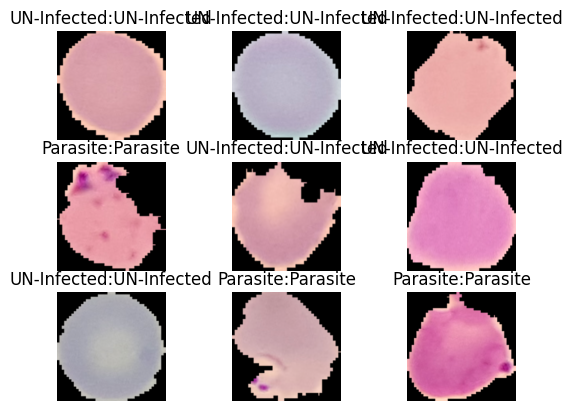

In [32]:
for i, (img, label) in enumerate(test.take(9)):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(img[0])
    plt.title(str(MalPredict(label.numpy()[0]))+ ":" + str(MalPredict(model.predict(img)[0][0])))
    plt.axis('off')

## Model Subclass

In [20]:
class Feature_extractor(Layer):
    def __init__(self , filters , kernel_size , strides ,padding,activation,pool_size ):
        super(Feature_extractor, self).__init__()

        self.conv_1 =Conv2D(filters=filters,kernel_size = kernel_size,strides = strides ,padding = padding, activation = activation  )
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size =pool_size , strides = 2*strides )
        self.conv_2 = Conv2D(filters=filters,kernel_size = kernel_size,strides = strides ,padding = padding, activation = activation  )
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size  , strides = 2*strides )
def call(self , x):
    x  = self.conv_1(x)
    x  = self.batch_1(x)
    x  = self.pool_1(x)

    x  = self.conv_2(x)
    x  = self.batch_2(x)
    x  = self.pool_2(x)

    return x



In [21]:
class LenetModel(Model):
    def __init__(self  ):
        super(LenetModel, self).__init__()

        self.feature_extractor =Feature_extractor( 8 , 3 ,1 ,'valid','relu', 2)
        self.flatten = Flatten()
        self.Dense_1 = Dense(100 , activation = 'relu')
        self.Batch_1 = BatchNormalization()

        self.Dense_2 = Dense(10 , activation = 'relu')
        self.Batch_2 = BatchNormalization()

        self.Dense_3 = Dense(1 , activation = 'sigmoid')

    def call(self , x, training):

        x  = self.feature_extractor(x)
        x = self.flatten(x)
        x  = self.Dense_1(x)
        x  = self.Batch_1(x)

        x  = self.Dense_2(x)
        x  = self.Batch_2(x)

        x  = self.Dense_3(x)

        return x

        
Lenet_sub_classed = LenetModel()
Lenet_sub_classed(tf.zeros([1,224,224,3]))
Lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (Feature  multiple                  0         
 _extractor)                                                     
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  15052900  
                                                                 
 batch_normalization_6 (Bat  multiple                  400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_7 (Bat  multiple                  